In [1]:
import numpy as np 
import pandas as pd 
import os
import zipfile
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt

data_root = 'plates/'
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device


c:\Study\Computer vision\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

In [6]:
# with zipfile.ZipFile('input/plates.zip', 'r') as zip_obj:    
#    zip_obj.extractall('/kaggle/working/')

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 5 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))


100%|██████████| 100/100 [00:00<00:00, 1111.14it/s]


In [2]:
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
    transforms.RandomChoice([transforms.CenterCrop(180),
                                transforms.CenterCrop(160),
                                transforms.CenterCrop(140),
                                transforms.CenterCrop(120),
                                transforms.Compose([transforms.CenterCrop(280),
                                                    transforms.Grayscale(3),
                                                    ]),
                                transforms.Compose([transforms.CenterCrop(200),
                                                    transforms.Grayscale(3),
                                                    ]),
                                ]),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

def train_model(model, loss, optimizer, scheduler, num_epochs):
    train_loss_list, val_loss_list, train_acc_list, val_acc_list = [], [], [], []
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        #scheduler.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean().cpu().numpy()

            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)
                if epoch_loss <= best_valid_loss:
                    best_valid_loss = epoch_loss
                    model_scripted = torch.jit.script(model)
                    model_scripted.save('model_scripted.pt') 

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

c:\Study\Computer vision\env\lib\site-packages\torchvision\transforms\transforms.py:768: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [3]:
class MyResNet50(torch.nn.Module):
    def __init__(self):
        super(MyResNet50, self).__init__()
        self.net = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        
        for param in self.net.parameters():
            param.requires_grad = False                
        
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
            # torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
        )  
    def forward(self, x):
        x = self.net(x)
        return x

In [6]:
class MyResNet18(torch.nn.Module):
    def __init__(self):
        super(MyResNet18, self).__init__()
        self.net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        for param in self.net.parameters():
            param.requires_grad = False                
        
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
            # torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
        )  
    def forward(self, x):
        x = self.net(x)
        return x

Epoch 0/29:


c:\Study\Computer vision\env\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 20/20 [00:12<00:00,  1.59it/s]

train Loss: 0.6618 Acc: 0.5687



100%|██████████| 5/5 [00:00<00:00, 17.67it/s]


val Loss: 0.5899 Acc: 0.7250
Epoch 1/29:


100%|██████████| 20/20 [00:01<00:00, 14.74it/s]

train Loss: 0.5370 Acc: 0.7375



100%|██████████| 5/5 [00:00<00:00, 24.16it/s]


val Loss: 0.5199 Acc: 0.7500
Epoch 2/29:


100%|██████████| 20/20 [00:01<00:00, 15.74it/s]

train Loss: 0.3366 Acc: 0.8938



100%|██████████| 5/5 [00:00<00:00, 25.25it/s]


val Loss: 0.3453 Acc: 0.8500
Epoch 3/29:


100%|██████████| 20/20 [00:01<00:00, 15.86it/s]

train Loss: 0.3539 Acc: 0.8438



100%|██████████| 5/5 [00:00<00:00, 26.46it/s]


val Loss: 0.3393 Acc: 0.8000
Epoch 4/29:


100%|██████████| 20/20 [00:01<00:00, 15.41it/s]

train Loss: 0.2596 Acc: 0.8875



100%|██████████| 5/5 [00:00<00:00, 26.60it/s]


val Loss: 0.2513 Acc: 0.9250
Epoch 5/29:


100%|██████████| 20/20 [00:01<00:00, 16.17it/s]

train Loss: 0.2467 Acc: 0.9125



100%|██████████| 5/5 [00:00<00:00, 27.03it/s]

val Loss: 0.2681 Acc: 0.9250
Epoch 6/29:



100%|██████████| 20/20 [00:01<00:00, 16.42it/s]

train Loss: 0.2116 Acc: 0.9125



100%|██████████| 5/5 [00:00<00:00, 26.88it/s]

val Loss: 0.2575 Acc: 0.9000
Epoch 7/29:



100%|██████████| 20/20 [00:01<00:00, 16.71it/s]

train Loss: 0.1660 Acc: 0.9563



100%|██████████| 5/5 [00:00<00:00, 26.46it/s]

val Loss: 0.3177 Acc: 0.8250
Epoch 8/29:



100%|██████████| 20/20 [00:01<00:00, 15.23it/s]

train Loss: 0.1749 Acc: 0.9313



100%|██████████| 5/5 [00:00<00:00, 27.03it/s]

val Loss: 0.2806 Acc: 0.9000
Epoch 9/29:



100%|██████████| 20/20 [00:01<00:00, 16.00it/s]

train Loss: 0.1908 Acc: 0.9250



100%|██████████| 5/5 [00:00<00:00, 27.32it/s]

val Loss: 0.2802 Acc: 0.9000
Epoch 10/29:



100%|██████████| 20/20 [00:01<00:00, 15.28it/s]

train Loss: 0.2152 Acc: 0.9250



100%|██████████| 5/5 [00:00<00:00, 27.17it/s]

val Loss: 0.2793 Acc: 0.8750
Epoch 11/29:



100%|██████████| 20/20 [00:01<00:00, 15.65it/s]

train Loss: 0.1749 Acc: 0.9313



100%|██████████| 5/5 [00:00<00:00, 27.47it/s]

val Loss: 0.2783 Acc: 0.9000
Epoch 12/29:



100%|██████████| 20/20 [00:01<00:00, 16.42it/s]

train Loss: 0.1950 Acc: 0.9062



100%|██████████| 5/5 [00:00<00:00, 27.32it/s]

val Loss: 0.3121 Acc: 0.8750
Epoch 13/29:



100%|██████████| 20/20 [00:01<00:00, 15.64it/s]

train Loss: 0.2539 Acc: 0.8938



100%|██████████| 5/5 [00:00<00:00, 27.03it/s]

val Loss: 0.2809 Acc: 0.8750
Epoch 14/29:



100%|██████████| 20/20 [00:01<00:00, 15.43it/s]

train Loss: 0.1694 Acc: 0.9437



100%|██████████| 5/5 [00:00<00:00, 27.17it/s]

val Loss: 0.2554 Acc: 0.9000
Epoch 15/29:



100%|██████████| 20/20 [00:01<00:00, 15.55it/s]

train Loss: 0.2964 Acc: 0.8812



100%|██████████| 5/5 [00:00<00:00, 26.18it/s]

val Loss: 0.2712 Acc: 0.8500
Epoch 16/29:



100%|██████████| 20/20 [00:01<00:00, 16.13it/s]

train Loss: 0.2177 Acc: 0.9062



100%|██████████| 5/5 [00:00<00:00, 26.32it/s]

val Loss: 0.2864 Acc: 0.8500
Epoch 17/29:



100%|██████████| 20/20 [00:01<00:00, 15.97it/s]

train Loss: 0.2354 Acc: 0.9000



100%|██████████| 5/5 [00:00<00:00, 26.04it/s]

val Loss: 0.2817 Acc: 0.9000
Epoch 18/29:



100%|██████████| 20/20 [00:01<00:00, 15.34it/s]

train Loss: 0.1459 Acc: 0.9625



100%|██████████| 5/5 [00:00<00:00, 26.46it/s]

val Loss: 0.2787 Acc: 0.9000
Epoch 19/29:



100%|██████████| 20/20 [00:01<00:00, 16.68it/s]

train Loss: 0.1902 Acc: 0.9250



100%|██████████| 5/5 [00:00<00:00, 27.03it/s]

val Loss: 0.3234 Acc: 0.9000
Epoch 20/29:



100%|██████████| 20/20 [00:01<00:00, 16.04it/s]

train Loss: 0.1723 Acc: 0.9313



100%|██████████| 5/5 [00:00<00:00, 26.60it/s]

val Loss: 0.2870 Acc: 0.8500
Epoch 21/29:



100%|██████████| 20/20 [00:01<00:00, 15.50it/s]

train Loss: 0.1562 Acc: 0.9563



100%|██████████| 5/5 [00:00<00:00, 26.60it/s]

val Loss: 0.2630 Acc: 0.8750
Epoch 22/29:



100%|██████████| 20/20 [00:01<00:00, 15.14it/s]

train Loss: 0.2482 Acc: 0.9062



100%|██████████| 5/5 [00:00<00:00, 26.88it/s]

val Loss: 0.2658 Acc: 0.9000
Epoch 23/29:



100%|██████████| 20/20 [00:01<00:00, 15.54it/s]

train Loss: 0.1673 Acc: 0.9563



100%|██████████| 5/5 [00:00<00:00, 27.17it/s]

val Loss: 0.2655 Acc: 0.9000
Epoch 24/29:



100%|██████████| 20/20 [00:01<00:00, 14.94it/s]

train Loss: 0.2263 Acc: 0.9187



100%|██████████| 5/5 [00:00<00:00, 25.64it/s]

val Loss: 0.2601 Acc: 0.8750
Epoch 25/29:



100%|██████████| 20/20 [00:01<00:00, 16.01it/s]

train Loss: 0.1981 Acc: 0.9375



100%|██████████| 5/5 [00:00<00:00, 26.88it/s]

val Loss: 0.2983 Acc: 0.8500
Epoch 26/29:



100%|██████████| 20/20 [00:01<00:00, 16.37it/s]

train Loss: 0.1981 Acc: 0.9000



100%|██████████| 5/5 [00:00<00:00, 26.60it/s]

val Loss: 0.2565 Acc: 0.9000
Epoch 27/29:



100%|██████████| 20/20 [00:01<00:00, 16.03it/s]

train Loss: 0.2203 Acc: 0.9125



100%|██████████| 5/5 [00:00<00:00, 26.18it/s]

val Loss: 0.2807 Acc: 0.8500
Epoch 28/29:



100%|██████████| 20/20 [00:01<00:00, 15.58it/s]

train Loss: 0.1900 Acc: 0.9000



100%|██████████| 5/5 [00:00<00:00, 26.74it/s]

val Loss: 0.2993 Acc: 0.8750
Epoch 29/29:



100%|██████████| 20/20 [00:01<00:00, 16.21it/s]

train Loss: 0.1853 Acc: 0.9375



100%|██████████| 5/5 [00:00<00:00, 26.46it/s]

val Loss: 0.2881 Acc: 0.9000


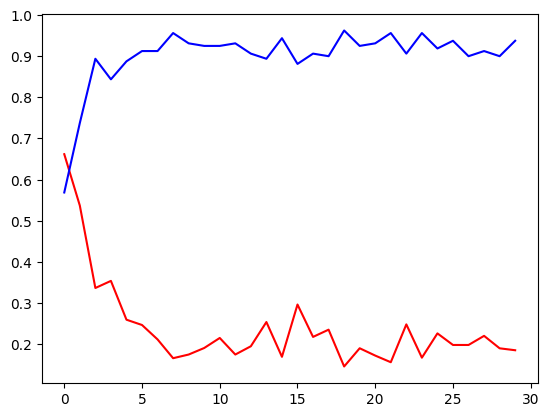

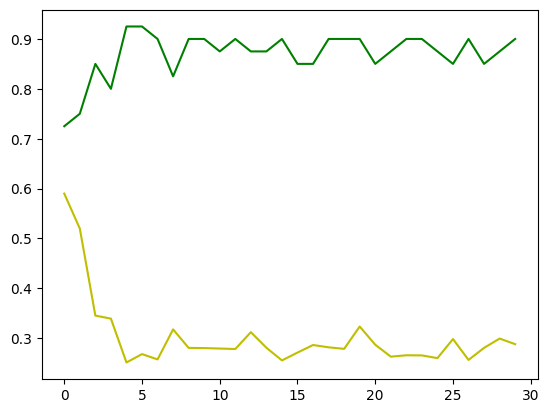

In [7]:
model = MyResNet18().to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


train_loss_list, val_loss_list, train_acc_list, val_acc_list = train_model(model, loss, optimizer, scheduler, num_epochs=30)


plt.plot(train_loss_list, c='r')
plt.plot(train_acc_list, c='b')
plt.show()
plt.plot(val_loss_list, c='y')
plt.plot(val_acc_list, c='g')
plt.show()

In [9]:
def accuracy(test_predictions, test_lables):
    top_1 = sum(map(lambda x, y: (1 if x > 0.5 else 0) == y, test_predictions, test_lables)) / len(test_predictions) * 100 
    return top_1

test_dir = data_root + 'test'
test_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=20, shuffle=False, num_workers=0)

test_predictions = []
test_lables = []
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions += list(torch.nn.functional.softmax(preds, dim=1)[:,1].data)
    test_lables += list(labels)
print('Accuracy: {:.2f}%' .format(accuracy(test_predictions, test_lables)))



100%|██████████| 5/5 [00:00<00:00, 16.18it/s]

Accuracy: 92.00%
